In [1]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from load_middlebury import read_calib, create_depth_map, read_pfm

import stereoblock
import stereodp
import stereograph
import stereoutil

In [2]:
stereo_folder = './input/Pipes-perfect'

In [3]:
scale = 0.20

right = cv2.imread(os.path.join(stereo_folder, 'im0.png'),0)
left = cv2.imread(os.path.join(stereo_folder, 'im1.png'),0)

left_small = cv2.resize(left, None, fx=scale, fy=scale).astype(np.float32)
right_small = cv2.resize(right, None, fx=scale, fy=scale).astype(np.float32)

print(left_small.shape, right_small.shape)

(385, 592) (385, 592)


In [4]:
calib_file_path = os.path.join(stereo_folder, 'calib.txt')
calib = read_calib(calib_file_path)
baseline = float(calib['baseline'])
doffs = float(calib['doffs'])
f = float(calib['cam0'][1:].split(" ")[0])
print(calib)

{'cam0': '[3968.297 0 1188.925; 0 3968.297 979.657; 0 0 1]', 'cam1': '[3968.297 0 1266.14; 0 3968.297 979.657; 0 0 1]', 'doffs': '77.215', 'baseline': '236.922', 'width': '2960', 'height': '1924', 'ndisp': '300', 'isint': '0', 'vmin': '28', 'vmax': '276', 'dyavg': '0', 'dymax': '0'}


In [5]:
dmap_truth, [(height, width, channels), _] = read_pfm(os.path.join(stereo_folder, 'disp1.pfm'))
dmap_truth = np.reshape(dmap_truth, newshape=(height, width, channels))
dmap_truth = np.flipud(dmap_truth)
dmap_truth_small = cv2.resize(dmap_truth, None, fx=scale, fy=scale).astype('float')
where_are_finite = np.isfinite(dmap_truth_small)
dmap_truth_small[~where_are_finite] = 0.0
dmap_truth_small *= scale
min_truth = np.min(dmap_truth_small)
max_truth = np.max(dmap_truth_small)
print("Min:", min_truth, "Max:", max_truth)

Min: 0.0 Max: 53.9689208984375


In [6]:
start_time = time.time()
dmap_block = stereoblock.disparity(left_small, right_small, window_size=11, disparity_range=60)
print("Block Match took {} seconds.".format(time.time()-start_time))

Block Match took 79.14290952682495 seconds.


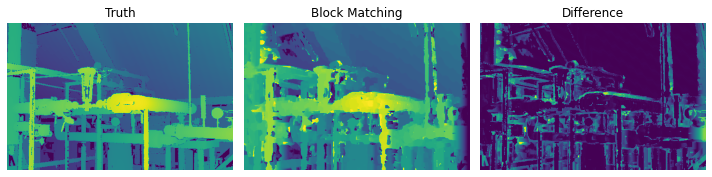

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1, 3, 1)
plt.imshow(dmap_truth_small)
plt.axis('off')
plt.title("Truth")
plt.subplot(1, 3, 2)
plt.imshow(np.clip(dmap_block,0,np.ceil(max_truth)))
#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.title("Block Matching")
plt.subplot(1, 3, 3)
diff_dmap_block = np.clip(np.abs(dmap_truth_small-dmap_block),0,max_truth)
plt.imshow(diff_dmap_block)
#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.title("Difference")
plt.show()

In [8]:
block_accuracy = stereoutil.get_accuracy(dmap_truth_small, dmap_block, scale)
print(block_accuracy)

0.42304756054756054


In [9]:
start_time = time.time()
dmap_graph = stereograph.disparity(right_small, left_small)
print("Graph-Cut took {} seconds.".format(time.time()-start_time))

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 3, 1)
plt.imshow(dmap_truth_small)
plt.axis('off')
plt.title("Truth")
plt.subplot(1, 3, 2)
plt.imshow(np.clip(dmap_graph,0,np.ceil(max_truth)))
#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.title("Graph Cut")
plt.subplot(1, 3, 3)
diff_dmap_graph = np.clip(np.abs(dmap_truth_small-dmap_graph),0,max_truth)
plt.imshow(diff_dmap_graph)
#plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.title("Difference")
plt.show()

In [ ]:
graph_accuracy = stereoutil.get_accuracy(dmap_truth_small, dmap_graph, scale)
print(graph_accuracy)